In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product e.csv', parse_dates=['Month-Year'])


In [3]:
sales_e= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_e = sales_e.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_e.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,57650,303130,2978499
1,2019-02-01,66035,347219,3411712
2,2019-03-01,88208,463807,4557285
3,2019-04-01,74712,392844,3860011
4,2019-05-01,61172,321649,3160464


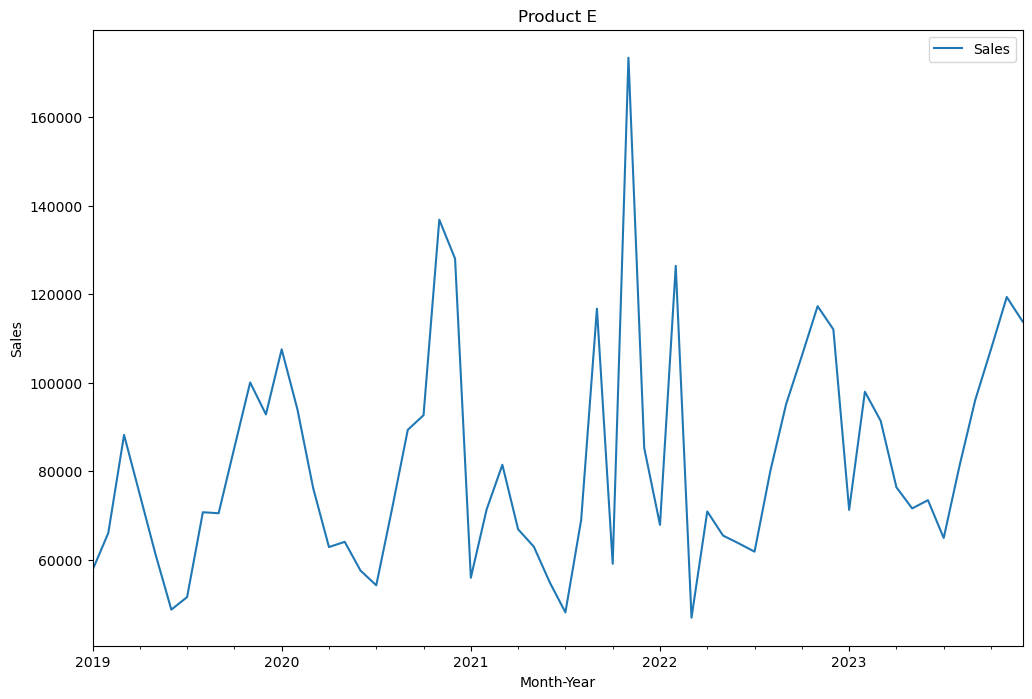

In [5]:
ax = sales_e.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product E')
plt.legend(['Sales'])
plt.show()


In [6]:
train= sales_e[:57]
test=sales_e[57:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='90 days', horizon = '90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

11:44:14 - cmdstanpy - INFO - Chain [1] start processing
11:44:15 - cmdstanpy - INFO - Chain [1] done processing
11:44:21 - cmdstanpy - INFO - Chain [1] start processing
11:44:21 - cmdstanpy - INFO - Chain [1] done processing
11:44:33 - cmdstanpy - INFO - Chain [1] start processing
11:44:33 - cmdstanpy - INFO - Chain [1] done processing
11:44:39 - cmdstanpy - INFO - Chain [1] start processing
11:44:40 - cmdstanpy - INFO - Chain [1] done processing
11:44:47 - cmdstanpy - INFO - Chain [1] start processing
11:44:48 - cmdstanpy - INFO - Chain [1] done processing
11:44:55 - cmdstanpy - INFO - Chain [1] start processing
11:44:55 - cmdstanpy - INFO - Chain [1] done processing
11:45:07 - cmdstanpy - INFO - Chain [1] start processing
11:45:08 - cmdstanpy - INFO - Chain [1] done processing
11:45:15 - cmdstanpy - INFO - Chain [1] start processing
11:45:18 - cmdstanpy - INFO - Chain [1] done processing
11:45:26 - cmdstanpy - INFO - Chain [1] start processing
11:45:26 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0   28748.445385  
1   27191.984621  
2   26198.779764  
3   24383.568144  
4   25432.996760  
..       

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
56,0.300,5.00,additive,23966.705346
42,0.200,3.00,additive,24149.170980
15,0.010,0.10,multiplicative,24293.209848
58,0.300,10.00,additive,24327.898226
40,0.200,1.00,additive,24349.191947
...,...,...,...,...
36,0.200,0.01,additive,28266.159588
60,0.500,0.01,additive,28301.558925
12,0.010,0.01,additive,28597.998814
24,0.100,0.01,additive,28620.844532


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive'}


In [10]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.3, seasonality_prior_scale=5.0, seasonality_mode='additive', interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [11]:
model.fit(train)

12:11:03 - cmdstanpy - INFO - Chain [1] start processing
12:11:03 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
len(test)

3

In [13]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [14]:
future_dates['Market Size'] = sales_e['Market Size']
future_dates['Marketing Expense'] = sales_e['Marketing Expense']

In [15]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,303130,2978499
1,2019-02-01,347219,3411712
2,2019-03-01,463807,4557285
3,2019-04-01,392844,3860011
4,2019-05-01,321649,3160464
5,2019-06-01,256180,2517181
6,2019-07-01,271087,2663652
7,2019-08-01,371885,3654074
8,2019-09-01,370707,3642501
9,2019-10-01,526105,5169414


In [16]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [17]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

In [18]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
57,2023-10-01,103945.327390,83538.999684,126337.288767
58,2023-11-01,123961.390097,101519.654275,146722.509388
59,2023-12-01,107399.843033,85036.788976,128884.633804


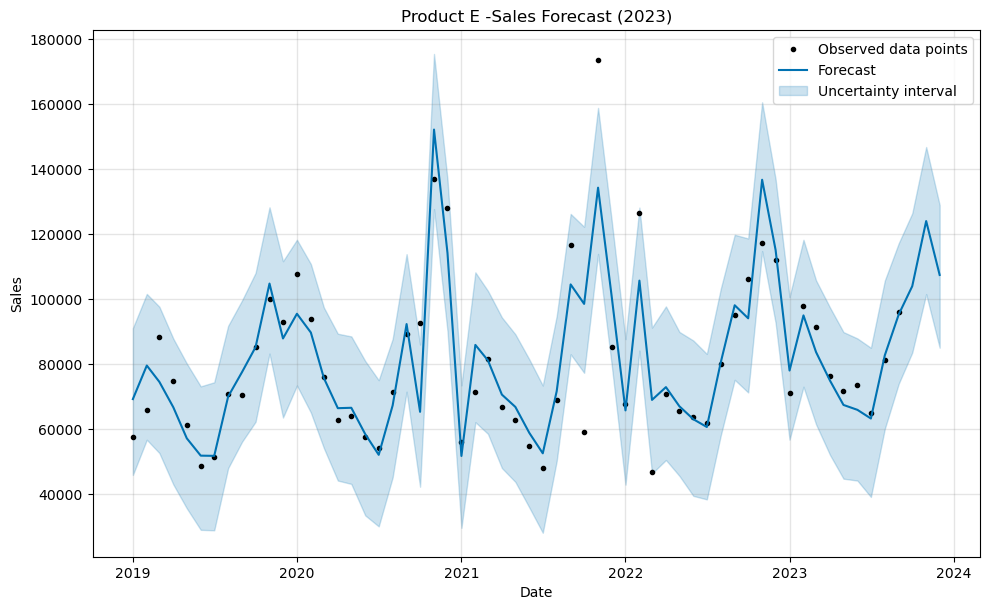

In [19]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product E -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

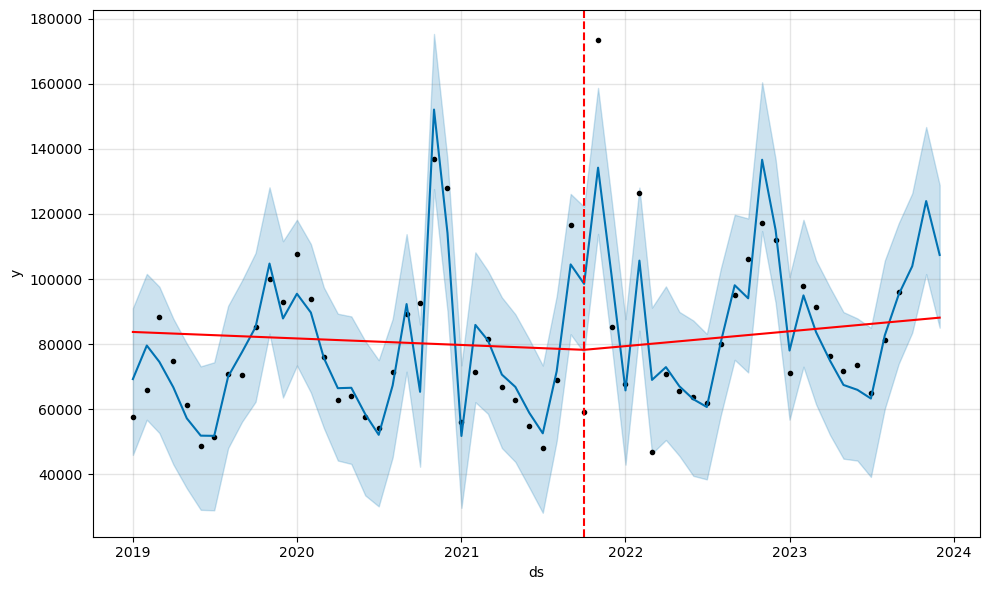

In [20]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

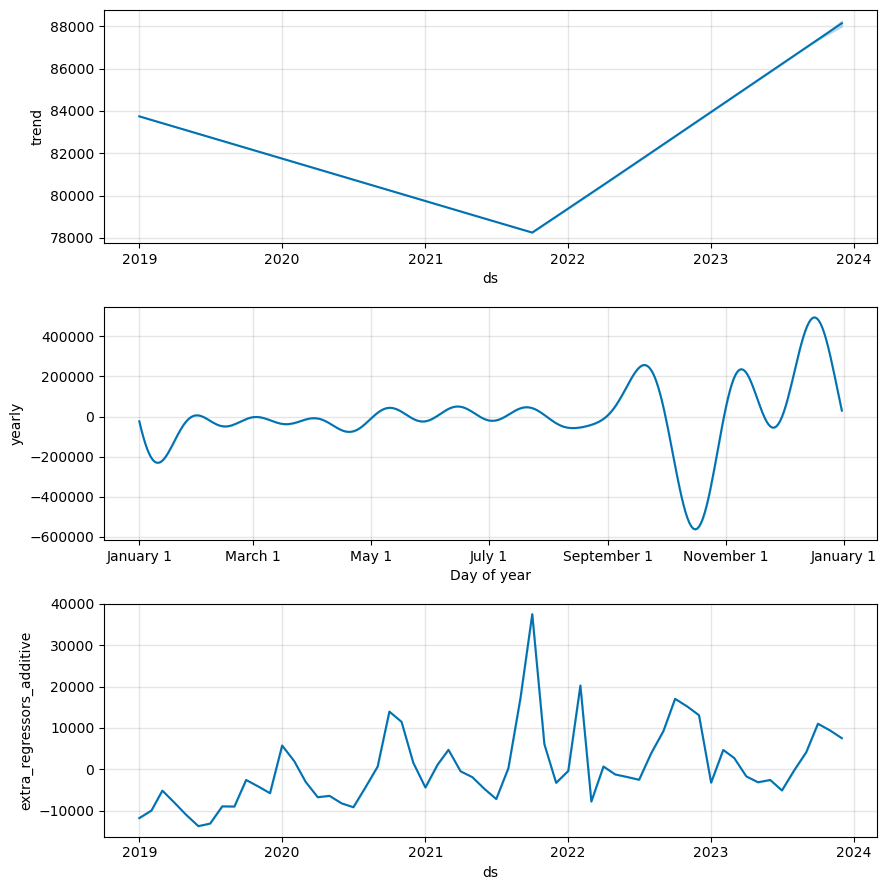

In [21]:
fig2 = model.plot_components(forecast)

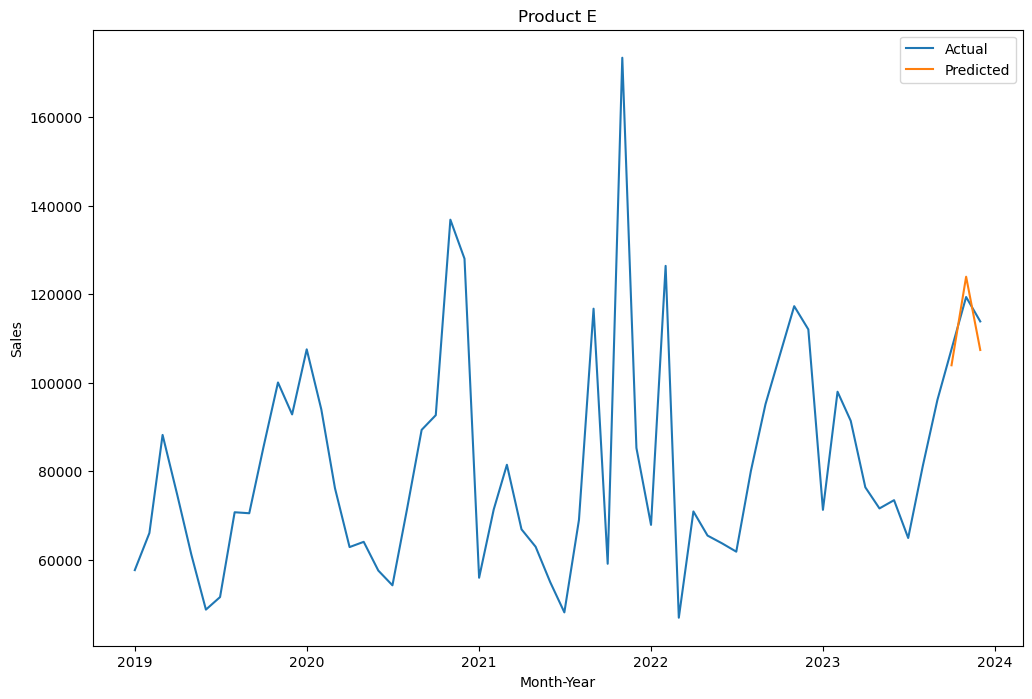

In [22]:
# Reset index of sales_b DataFrame
sales_e_reset_index = sales_e.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_e_reset_index['ds'], sales_e_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product E')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [23]:
#model evaluation

In [24]:
pred=forecasted_df['yhat']
test_df=test['y']

In [25]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 4892.740
MAPE - FB PROPHET: 0.043
MSE - FB PROPHET: 25308559.243
RMSE - FB PROPHET: 5030.761


In [26]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='90 days', horizon='90 days', parallel="processes")

In [27]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,20 days,2.800944e+09,52923.949359,32145.866669,0.546125,0.055614,0.320110,0.333333
1,22 days,2.815163e+09,53058.106849,33778.885804,0.563996,0.099464,0.340342,0.666667
2,23 days,3.592613e+07,5993.840616,5678.335718,0.086545,0.099464,0.091052,1.000000
3,25 days,2.126423e+08,14582.260196,11925.650561,0.137147,0.118102,0.149926,0.666667
4,27 days,1.970507e+08,14037.473270,10504.732292,0.109581,0.066457,0.119375,0.666667
5,28 days,1.419947e+07,3768.217787,3625.743662,0.050653,0.045788,0.051514,1.000000
6,47 days,1.015646e+07,3186.920799,3034.974532,0.044507,0.045788,0.045320,1.000000
7,49 days,2.400176e+07,4899.158655,4265.180770,0.063734,0.045788,0.062358,1.000000
8,51 days,1.039195e+09,32236.551635,21696.739458,0.154680,0.110768,0.173073,0.666667
9,52 days,1.049603e+09,32397.576727,22969.336053,0.173676,0.110768,0.193332,0.666667


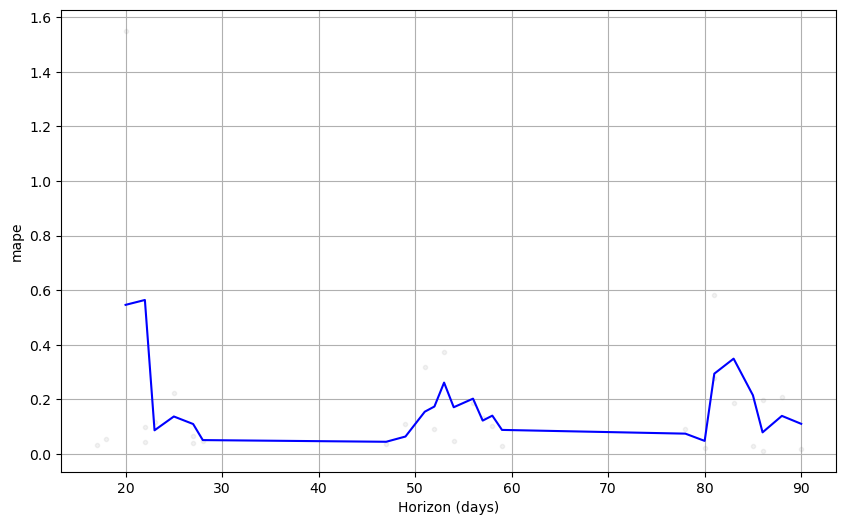

In [28]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [29]:
test_df

57    107582
58    119374
59    113854
Name: y, dtype: int64

In [30]:
pred

57    103945.327390
58    123961.390097
59    107399.843033
Name: yhat, dtype: float64